# MLM Masking Strategies Demo

This notebook demonstrates the masking strategies used in ModernMusicBERT:

- **Element**: Individual tokens masked independently
- **Compound**: All 8 tokens of a compound masked together
- **Bar**: All compounds sharing the same (bar, instrument) pair masked together
- **Onset**: All compounds sharing the same (bar, position) masked together (captures chords)
- **Span**: Contiguous spans of compounds masked together (geometric distribution)
- **Onset-Span**: Contiguous spans of onsets masked together
- **Example-level**: Selected dimensions masked for entire sequences

The OctupleMIDI encoding uses 8 tokens per musical event:
`[bar, position, instrument, pitch, duration, velocity, time_sig, tempo]`

In [1]:
import sys
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch

from src.data.masking import get_masker
from src.data.constants import (
    COMPOUND_RATIO,
    DIMENSION_NAMES,
    PAD_TOKEN_ID,
    BOS_TOKEN_ID,
    EOS_TOKEN_ID,
    IGNORE_INDEX,
    OCT_VOCAB_SIZE,
)

In [2]:
def generate_synthetic_sequence(n_compounds: int) -> tuple[torch.Tensor, list[int]]:
    """Generate a synthetic OctupleMIDI sequence with irregular bar groupings.

    Returns:
        tokens: Token IDs tensor of shape (n_compounds * 8,)
        bar_boundaries: List of compound indices where each bar starts
    """
    seq_len = n_compounds * COMPOUND_RATIO
    tokens = torch.zeros(seq_len, dtype=torch.long)

    # Token ranges for each dimension (offset by 5 to skip special tokens)
    ranges = {
        "bar": (5, 5 + 10),  # Will override below
        "position": (5, 50),
        "instrument": (5, 10),
        "pitch": (5, 133),
        "duration": (5, 50),
        "velocity": (5, 37),
        "time_sig": (5, 20),
        "tempo": (5, 60),
    }

    # Irregular bar groupings: varying number of compounds per bar
    # For 16 compounds: bars of size 3, 4, 4, 5
    bar_sizes = [3, 4, 4, 5]
    while sum(bar_sizes) < n_compounds:
        bar_sizes.append(min(4, n_compounds - sum(bar_sizes)))
    # Trim if we went over
    while sum(bar_sizes) > n_compounds:
        bar_sizes[-1] -= 1
        if bar_sizes[-1] <= 0:
            bar_sizes.pop()

    # Build compound-to-bar mapping and bar boundaries
    bar_boundaries = []
    compound_to_bar = []
    compound_idx = 0
    for bar_idx, bar_size in enumerate(bar_sizes):
        bar_boundaries.append(compound_idx)
        for _ in range(bar_size):
            compound_to_bar.append(bar_idx)
            compound_idx += 1

    for c in range(n_compounds):
        base = c * COMPOUND_RATIO
        bar_num = compound_to_bar[c]

        for dim_idx, dim_name in enumerate(DIMENSION_NAMES):
            low, high = ranges[dim_name]
            if dim_name == "bar":
                tokens[base + dim_idx] = low + bar_num
            elif dim_name == "instrument":
                # Single instrument so all compounds in a bar share (bar, instrument)
                tokens[base + dim_idx] = low
            else:
                tokens[base + dim_idx] = torch.randint(low, high, (1,)).item()

    return tokens, bar_boundaries


def generate_batch(
    batch_size: int, n_compounds: int
) -> tuple[torch.Tensor, list[int]]:
    """Generate a batch of synthetic sequences.

    Returns:
        batch: Token IDs tensor of shape (batch_size, n_compounds * 8)
        bar_boundaries: Bar boundaries (same for all sequences)
    """
    sequences = []
    bar_boundaries = None
    for _ in range(batch_size):
        tokens, boundaries = generate_synthetic_sequence(n_compounds)
        sequences.append(tokens)
        if bar_boundaries is None:
            bar_boundaries = boundaries
    return torch.stack(sequences), bar_boundaries

In [3]:
def visualize_masking(
    input_ids: torch.Tensor,
    labels: torch.Tensor,
    title: str = "Masking Visualization",
    ax: plt.Axes | None = None,
    bar_boundaries: list[int] | None = None,
) -> plt.Axes:
    """Visualize masked vs unmasked tokens in a batch.

    Each row is a sequence, each column is a token position.
    Masked tokens (labels != -100) shown in red.
    Unmasked tokens shown in blue (even bars) or green (odd bars) shades.
    Compound boundaries marked with subtle grid lines.
    """
    batch_size, seq_len = input_ids.shape
    n_compounds = seq_len // COMPOUND_RATIO

    # Build token-to-bar mapping
    if bar_boundaries is not None:
        token_to_bar = np.zeros(seq_len, dtype=int)
        for bar_idx in range(len(bar_boundaries)):
            start_compound = bar_boundaries[bar_idx]
            end_compound = (
                bar_boundaries[bar_idx + 1]
                if bar_idx + 1 < len(bar_boundaries)
                else n_compounds
            )
            start_token = start_compound * COMPOUND_RATIO
            end_token = end_compound * COMPOUND_RATIO
            token_to_bar[start_token:end_token] = bar_idx
    else:
        token_to_bar = None

    # Create visualization array
    # Values: 0-1 = even bar unmasked, 1-2 = odd bar unmasked, 2-3 = masked
    vis_array = np.zeros((batch_size, seq_len))
    max_token = input_ids.max().item()
    normalized_tokens = (input_ids.float() / max_token).numpy()
    is_masked = (labels != IGNORE_INDEX).numpy()

    for b in range(batch_size):
        for t in range(seq_len):
            if is_masked[b, t]:
                # Masked: value in [2, 3] range
                vis_array[b, t] = 2.0 + normalized_tokens[b, t] * 0.5
            elif token_to_bar is not None and token_to_bar[t] % 2 == 1:
                # Odd bar unmasked: value in [1, 2] range
                vis_array[b, t] = 1.0 + normalized_tokens[b, t] * 0.8
            else:
                # Even bar unmasked: value in [0, 1] range
                vis_array[b, t] = normalized_tokens[b, t] * 0.8

    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 3))

    # Custom colormap: blues (0-1), greens (1-2), reds (2-3)
    blues = plt.cm.Blues(np.linspace(0.3, 0.8, 50))
    greens = plt.cm.Greens(np.linspace(0.3, 0.8, 50))
    reds = plt.cm.Reds(np.linspace(0.5, 0.9, 50))
    colors = np.vstack([blues, greens, reds])
    cmap = ListedColormap(colors)

    im = ax.imshow(vis_array, aspect="auto", cmap=cmap, vmin=0, vmax=3.0)

    # Add compound boundary lines
    for i in range(1, n_compounds):
        ax.axvline(x=i * COMPOUND_RATIO - 0.5, color="gray", linewidth=0.5, alpha=0.5)

    # Add bar boundary lines (thicker)
    if bar_boundaries is not None:
        for bar_start in bar_boundaries[1:]:  # Skip first bar (starts at 0)
            ax.axvline(
                x=bar_start * COMPOUND_RATIO - 0.5,
                color="black",
                linewidth=1.5,
                alpha=0.7,
            )

    ax.set_title(title)
    ax.set_xlabel("Token position")
    ax.set_ylabel("Batch index")
    ax.set_yticks(range(batch_size))

    # Add legend
    legend_elements = [
        Patch(facecolor=plt.cm.Blues(0.5), label="Unmasked (even bar)"),
        Patch(facecolor=plt.cm.Greens(0.5), label="Unmasked (odd bar)"),
        Patch(facecolor=plt.cm.Reds(0.7), label="Masked"),
    ]
    ax.legend(handles=legend_elements, loc="upper right", fontsize=8)

    return ax

## Generate Test Data

We'll generate a batch of 8 sequences, each with 16 compounds (128 tokens).

In [4]:
# Parameters
BATCH_SIZE = 8
N_COMPOUNDS = 16  # 128 tokens
MASK_PROB = 0.15

# Generate synthetic data
torch.manual_seed(42)
input_ids, bar_boundaries = generate_batch(BATCH_SIZE, N_COMPOUNDS)

print(f"Input shape: {input_ids.shape}")
print(f"Sequence length: {input_ids.shape[1]} tokens = {input_ids.shape[1] // COMPOUND_RATIO} compounds")
print(f"Bar boundaries (compound indices): {bar_boundaries}")

Input shape: torch.Size([8, 128])
Sequence length: 128 tokens = 16 compounds
Bar boundaries (compound indices): [0, 3, 7, 11]


## Element Masking

Each token is independently masked with probability 15%. Tokens within the same compound can have different mask states.

Element masking: 170/1024 tokens masked (16.6%)


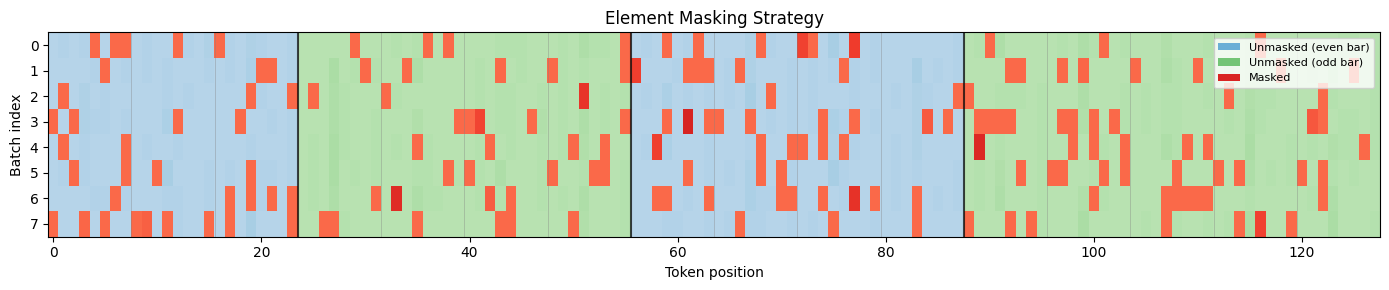

In [5]:
torch.manual_seed(123)
element_masker = get_masker("element")
masked_element, labels_element = element_masker(input_ids.clone(), MASK_PROB, OCT_VOCAB_SIZE)

n_masked = (labels_element != IGNORE_INDEX).sum().item()
total = labels_element.numel()
print(f"Element masking: {n_masked}/{total} tokens masked ({100*n_masked/total:.1f}%)")

visualize_masking(masked_element, labels_element, "Element Masking Strategy", bar_boundaries=bar_boundaries)
plt.tight_layout()
plt.show()

## Compound Masking

Entire compounds (all 8 tokens) are masked together. If any token in a compound is masked, all 8 are masked.

Compound masking: 18 compounds (144 tokens) masked (14.1%)


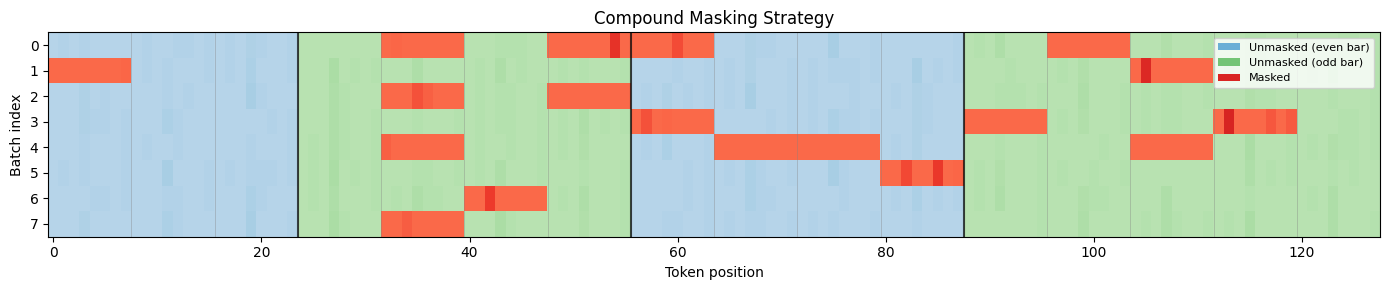

In [6]:
torch.manual_seed(123)
compound_masker = get_masker("compound")
masked_compound, labels_compound = compound_masker(input_ids.clone(), MASK_PROB, OCT_VOCAB_SIZE)

n_masked = (labels_compound != IGNORE_INDEX).sum().item()
total = labels_compound.numel()
n_compounds_masked = n_masked // COMPOUND_RATIO
print(f"Compound masking: {n_compounds_masked} compounds ({n_masked} tokens) masked ({100*n_masked/total:.1f}%)")

visualize_masking(masked_compound, labels_compound, "Compound Masking Strategy", bar_boundaries=bar_boundaries)
plt.tight_layout()
plt.show()

## Bar Masking

All compounds sharing the same (bar, instrument) pair are masked together. This captures musical structure by masking entire instrumental lines within a bar.

Bar masking: 248 tokens masked (24.2%)


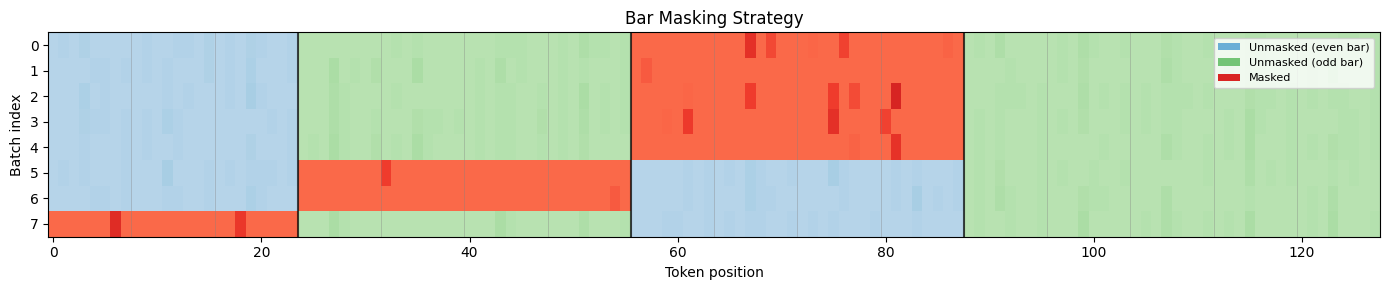

In [7]:
torch.manual_seed(123)
bar_masker = get_masker("bar")
masked_bar, labels_bar = bar_masker(input_ids.clone(), MASK_PROB, OCT_VOCAB_SIZE)

n_masked = (labels_bar != IGNORE_INDEX).sum().item()
total = labels_bar.numel()
print(f"Bar masking: {n_masked} tokens masked ({100*n_masked/total:.1f}%)")

visualize_masking(masked_bar, labels_bar, "Bar Masking Strategy", bar_boundaries=bar_boundaries)
plt.tight_layout()
plt.show()

## Onset Masking

All compounds sharing the same (bar, position) pair are masked together. This captures chords and simultaneous notes across different instruments at the same rhythmic position.

Onset masking: 128 tokens masked (12.5%)


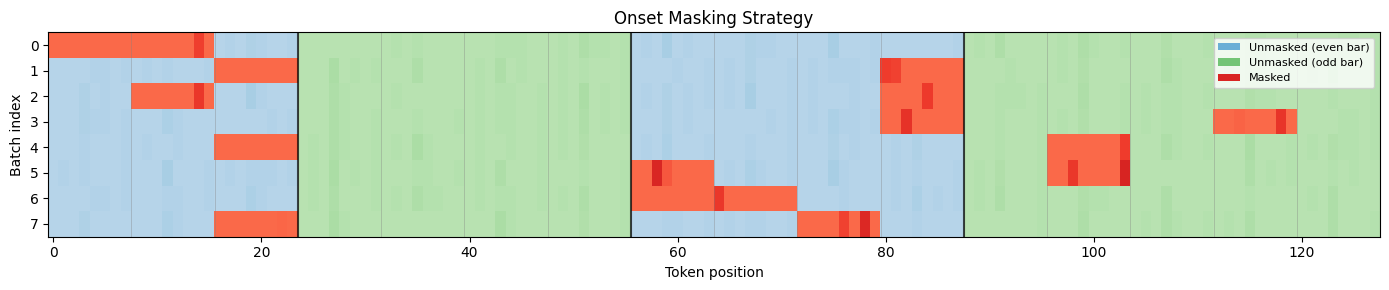

In [8]:
torch.manual_seed(123)
onset_masker = get_masker("onset")
masked_onset, labels_onset = onset_masker(input_ids.clone(), MASK_PROB, OCT_VOCAB_SIZE)

n_masked = (labels_onset != IGNORE_INDEX).sum().item()
total = labels_onset.numel()
print(f"Onset masking: {n_masked} tokens masked ({100*n_masked/total:.1f}%)")

visualize_masking(masked_onset, labels_onset, "Onset Masking Strategy", bar_boundaries=bar_boundaries)
plt.tight_layout()
plt.show()

## Dimension-Specific Onset Masking

Onset masking can target a single dimension (e.g., only pitch). All compounds at selected onsets are included, but only the specified dimension is actually masked.

Onset (pitch only) masking: 16 tokens masked (1.6%)
Note: Only dimension 3 (pitch) is masked at selected onsets


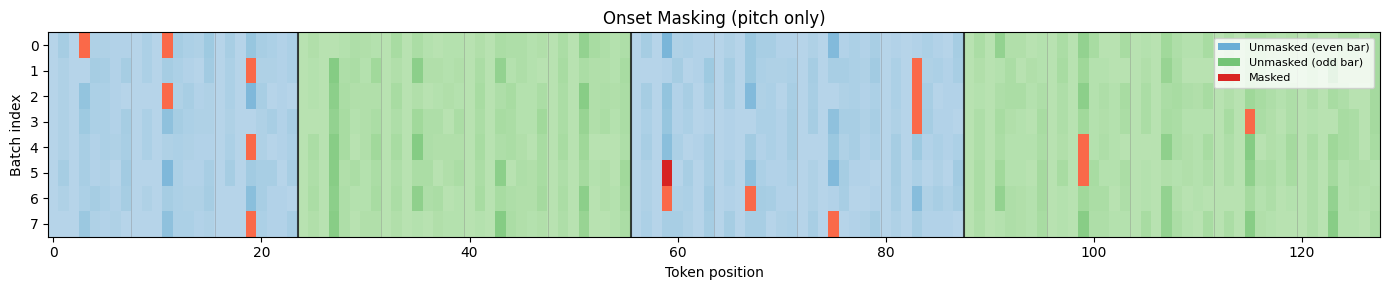

In [9]:
torch.manual_seed(123)
onset_pitch_masker = get_masker("onset:pitch")
masked_onset_pitch, labels_onset_pitch = onset_pitch_masker(input_ids.clone(), MASK_PROB, OCT_VOCAB_SIZE)

n_masked = (labels_onset_pitch != IGNORE_INDEX).sum().item()
total = labels_onset_pitch.numel()
print(f"Onset (pitch only) masking: {n_masked} tokens masked ({100*n_masked/total:.1f}%)")
print("Note: Only dimension 3 (pitch) is masked at selected onsets")

visualize_masking(masked_onset_pitch, labels_onset_pitch, "Onset Masking (pitch only)", bar_boundaries=bar_boundaries)
plt.tight_layout()
plt.show()

## Span Masking

Contiguous spans of compounds are masked together. Span lengths follow a geometric distribution with mean=3 and max=10, creating natural phrase-like masked regions.

We use 40% masking here (vs 15% elsewhere) to generate multiple spans and better demonstrate the distribution.

Span masking: 384 tokens masked (37.5%)


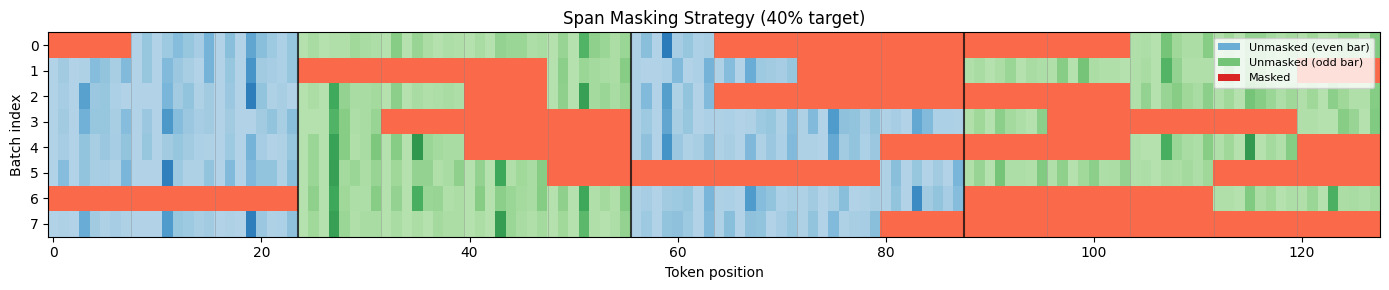

In [10]:
# Use higher mask_prob to show multiple spans and their length distribution
SPAN_MASK_PROB = 0.4

torch.manual_seed(123)
span_masker = get_masker("span")
masked_span, labels_span = span_masker(input_ids.clone(), SPAN_MASK_PROB, OCT_VOCAB_SIZE)

n_masked = (labels_span != IGNORE_INDEX).sum().item()
total = labels_span.numel()
print(f"Span masking: {n_masked} tokens masked ({100*n_masked/total:.1f}%)")

visualize_masking(masked_span, labels_span, "Span Masking Strategy (40% target)", bar_boundaries=bar_boundaries)
plt.tight_layout()
plt.show()

## Dimension-Specific Span Masking

Span masking can target a single dimension (e.g., only pitch). The spans are still contiguous at the compound level, but only one token per compound is actually masked.

Span (pitch only) masking: 48 tokens masked (4.7%)
Note: Only dimension 3 (pitch) is masked in contiguous spans


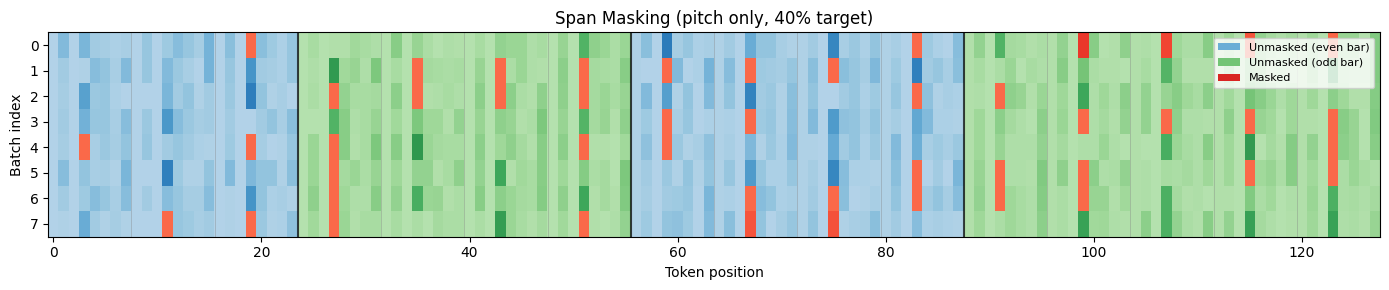

In [11]:
torch.manual_seed(123)
span_pitch_masker = get_masker("span:pitch")
masked_span_pitch, labels_span_pitch = span_pitch_masker(input_ids.clone(), SPAN_MASK_PROB, OCT_VOCAB_SIZE)

n_masked = (labels_span_pitch != IGNORE_INDEX).sum().item()
total = labels_span_pitch.numel()
print(f"Span (pitch only) masking: {n_masked} tokens masked ({100*n_masked/total:.1f}%)")
print("Note: Only dimension 3 (pitch) is masked in contiguous spans")

visualize_masking(masked_span_pitch, labels_span_pitch, "Span Masking (pitch only, 40% target)", bar_boundaries=bar_boundaries)
plt.tight_layout()
plt.show()

## Onset-Span Masking

Contiguous spans of onsets are masked together. Unlike regular span masking (which operates on compounds), onset-span masking groups by (bar, position) first, then masks contiguous spans of these onset groups. This creates musically coherent masked regions that respect rhythmic boundaries.

We use 40% masking here to generate multiple spans and demonstrate the distribution.

Onset-span masking: 384 tokens masked (37.5%)


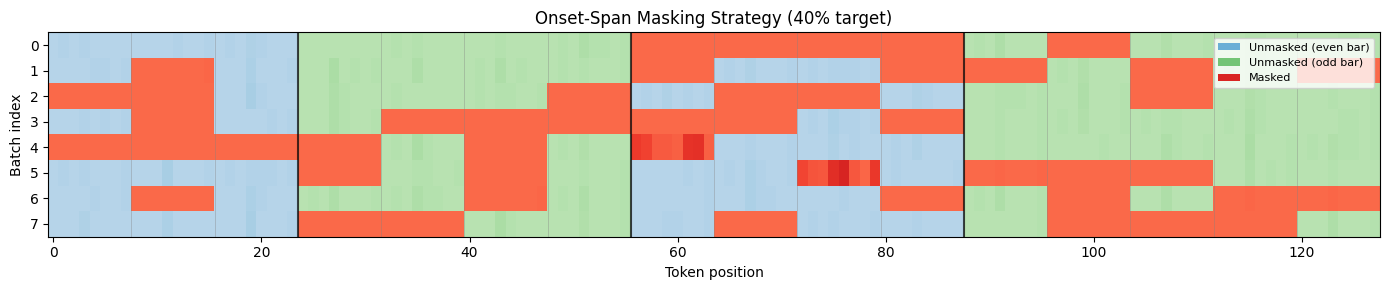

In [12]:
torch.manual_seed(123)
onset_span_masker = get_masker("onset_span")
masked_onset_span, labels_onset_span = onset_span_masker(input_ids.clone(), SPAN_MASK_PROB, OCT_VOCAB_SIZE)

n_masked = (labels_onset_span != IGNORE_INDEX).sum().item()
total = labels_onset_span.numel()
print(f"Onset-span masking: {n_masked} tokens masked ({100*n_masked/total:.1f}%)")

visualize_masking(masked_onset_span, labels_onset_span, "Onset-Span Masking Strategy (40% target)", bar_boundaries=bar_boundaries)
plt.tight_layout()
plt.show()

## Dimension-Specific Onset-Span Masking

Onset-span masking can target a single dimension (e.g., only pitch). Spans of onsets are selected, but only the specified dimension is actually masked within those spans.

Onset-span (pitch only) masking: 49 tokens masked (4.8%)
Note: Only dimension 3 (pitch) is masked in contiguous onset spans


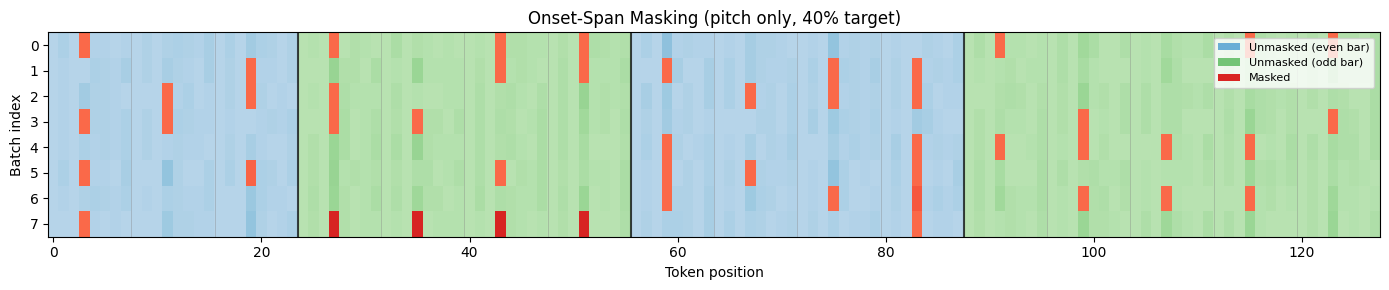

In [13]:
torch.manual_seed(123)
onset_span_pitch_masker = get_masker("onset_span:pitch")
masked_onset_span_pitch, labels_onset_span_pitch = onset_span_pitch_masker(input_ids.clone(), SPAN_MASK_PROB, OCT_VOCAB_SIZE)

n_masked = (labels_onset_span_pitch != IGNORE_INDEX).sum().item()
total = labels_onset_span_pitch.numel()
print(f"Onset-span (pitch only) masking: {n_masked} tokens masked ({100*n_masked/total:.1f}%)")
print("Note: Only dimension 3 (pitch) is masked in contiguous onset spans")

visualize_masking(masked_onset_span_pitch, labels_onset_span_pitch, "Onset-Span Masking (pitch only, 40% target)", bar_boundaries=bar_boundaries)
plt.tight_layout()
plt.show()

## Example-Level Masking

Selected dimensions (by default time_sig and tempo, indices 6-7) are masked for entire sequences. A subset of batch examples are selected, and all positions of the target dimensions are masked in those examples.

Example-level masking: 96 tokens masked (9.4%)
Note: Only dimensions 6-7 (time_sig, tempo) are masked, but for entire sequences


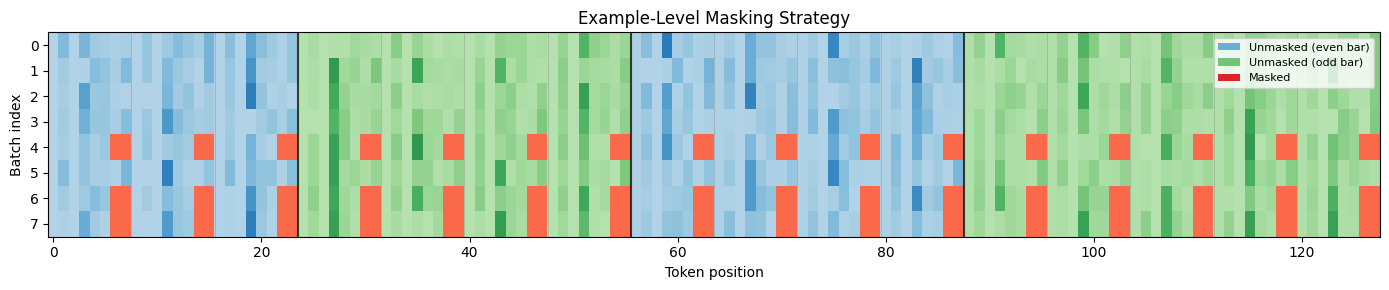

In [14]:
torch.manual_seed(123)
example_level_masker = get_masker("example_level")
masked_example, labels_example = example_level_masker(input_ids.clone(), MASK_PROB, OCT_VOCAB_SIZE)

n_masked = (labels_example != IGNORE_INDEX).sum().item()
total = labels_example.numel()
print(f"Example-level masking: {n_masked} tokens masked ({100*n_masked/total:.1f}%)")
print("Note: Only dimensions 6-7 (time_sig, tempo) are masked, but for entire sequences")

visualize_masking(masked_example, labels_example, "Example-Level Masking Strategy", bar_boundaries=bar_boundaries)
plt.tight_layout()
plt.show()

## Mixed Masking

The default strategy randomly samples one of the three strategies per sample in the batch. Each sequence may use a different masking strategy.

Mixed masking: 167 tokens masked (16.3%)


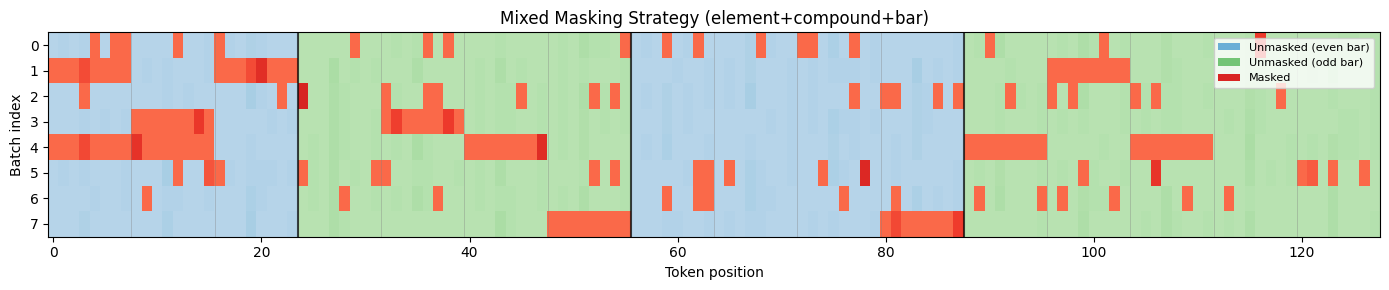

In [15]:
import random
torch.manual_seed(123)
random.seed(123)

mixed_masker = get_masker("element+compound+bar")
masked_mixed, labels_mixed = mixed_masker(input_ids.clone(), MASK_PROB, OCT_VOCAB_SIZE)

n_masked = (labels_mixed != IGNORE_INDEX).sum().item()
total = labels_mixed.numel()
print(f"Mixed masking: {n_masked} tokens masked ({100*n_masked/total:.1f}%)")

visualize_masking(masked_mixed, labels_mixed, "Mixed Masking Strategy (element+compound+bar)", bar_boundaries=bar_boundaries)
plt.tight_layout()
plt.show()

## Side-by-Side Comparison

Compare all eight strategies on the same input data.

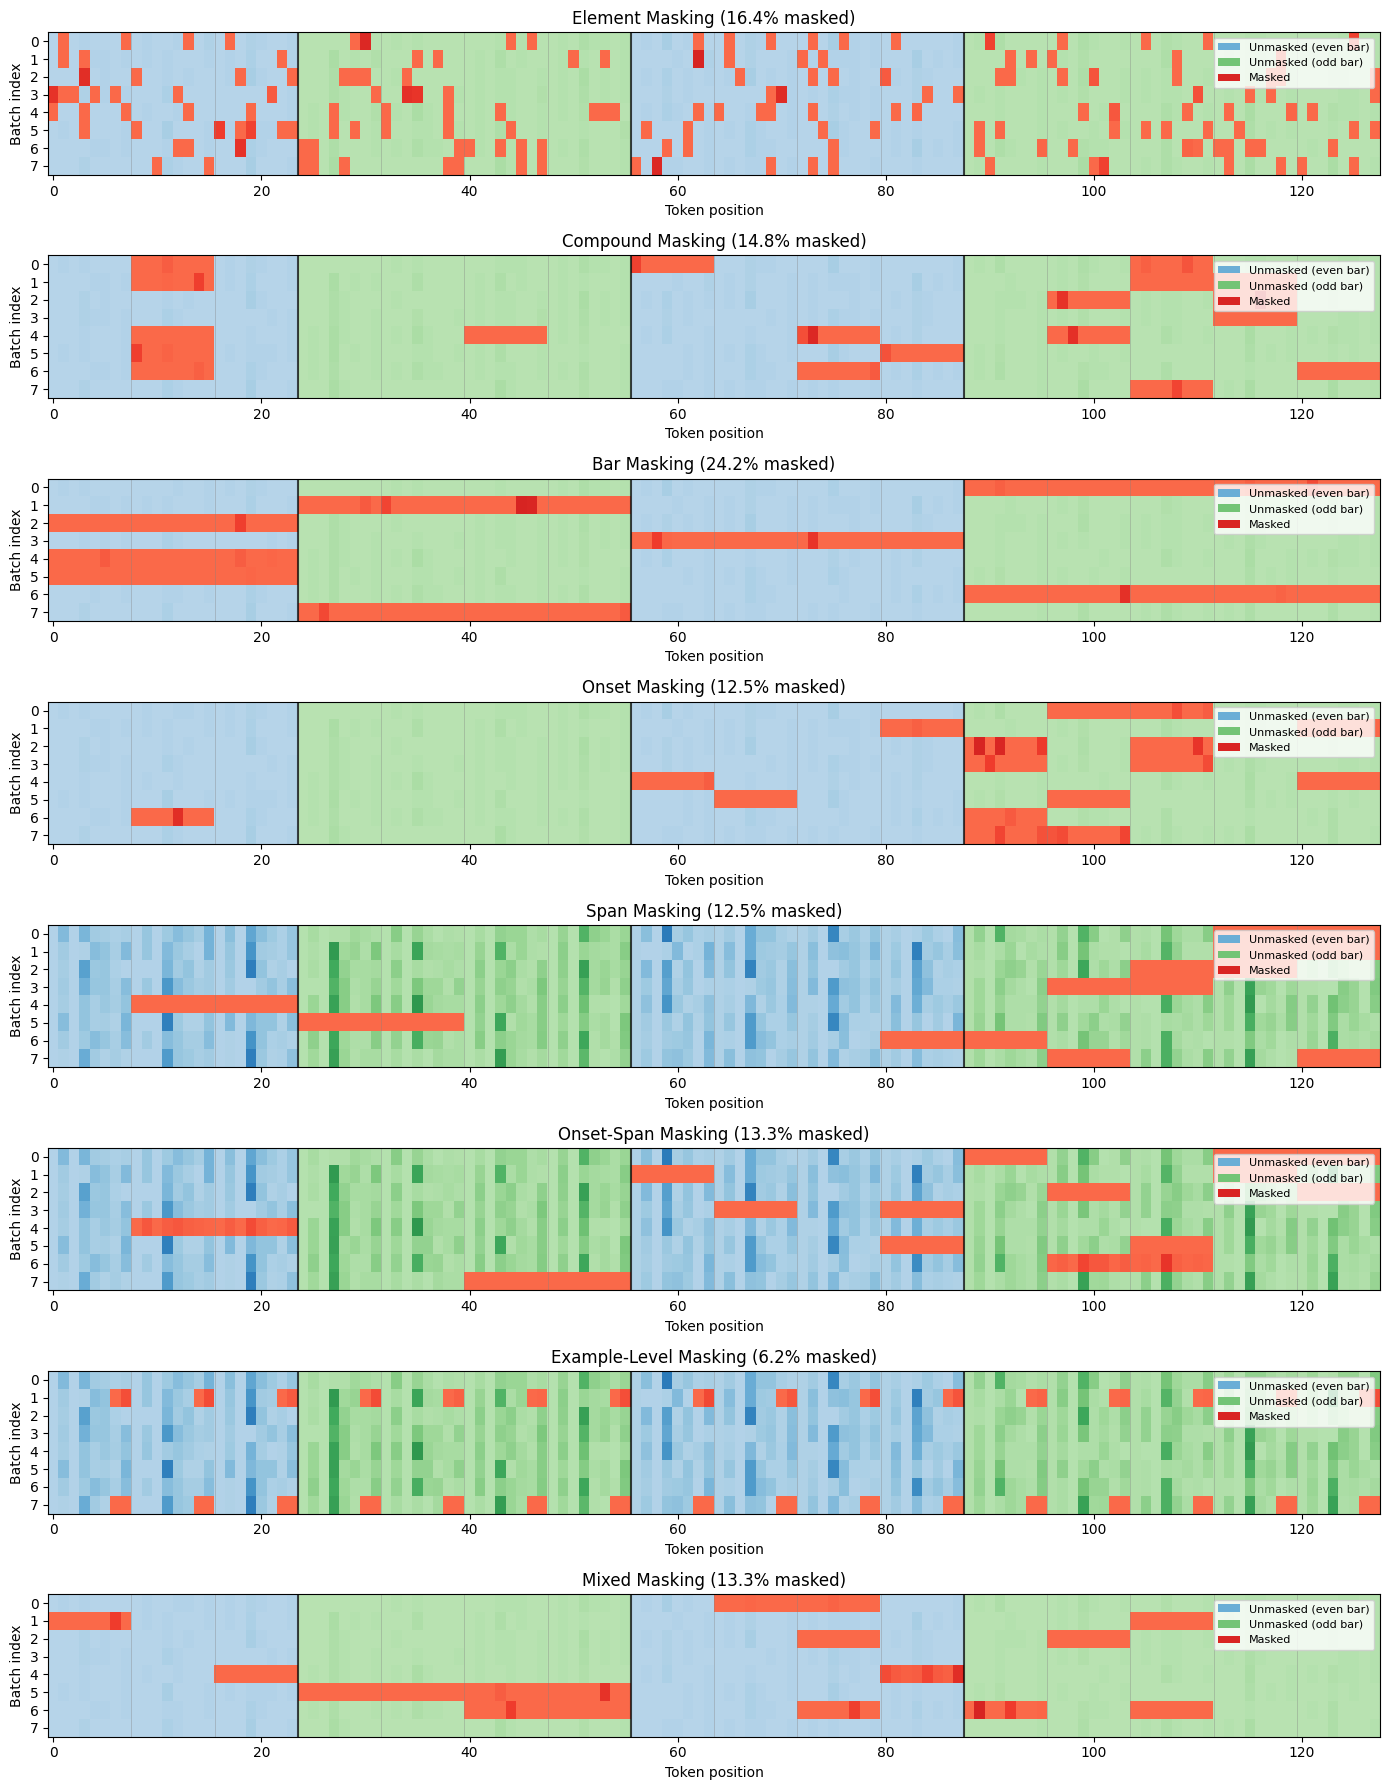

In [16]:
fig, axes = plt.subplots(8, 1, figsize=(14, 18))

strategies = [
    ("element", "Element"),
    ("compound", "Compound"),
    ("bar", "Bar"),
    ("onset", "Onset"),
    ("span", "Span"),
    ("onset_span", "Onset-Span"),
    ("example_level", "Example-Level"),
    ("element+compound+bar+onset+span+onset_span+example_level", "Mixed"),
]

for ax, (strategy, name) in zip(axes, strategies):
    torch.manual_seed(456)  # Same seed for fair comparison
    random.seed(456)

    masker = get_masker(strategy)
    masked, labels = masker(input_ids.clone(), MASK_PROB, OCT_VOCAB_SIZE)

    n_masked = (labels != IGNORE_INDEX).sum().item()
    pct = 100 * n_masked / labels.numel()

    visualize_masking(masked, labels, f"{name} Masking ({pct:.1f}% masked)", ax=ax, bar_boundaries=bar_boundaries)

plt.tight_layout()
plt.show()